A Multi-View Attention Fusion model for Automatic Modulation Classification.
Takes approximately an hour to run with a T4 GPU.
To run the code;


1.   Upload the RML2016.10a_dict.pkl dataset to the notebook directory
2.   Then run all cells.



Libraries and packages

In [1]:
# Import libraries and packages
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, utils
from tensorflow.keras.layers import GRU, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import zipfile
import seaborn as sns

Import dataset

In [2]:
# Load the RadioML 2016.10a dataset
with open('RML2016.10a_dict.pkl', 'rb') as f:
  Xd = pickle.load(f, encoding='latin1')

print("Dataset loaded successfully!")

Dataset loaded successfully!


Data preparation and visualisation

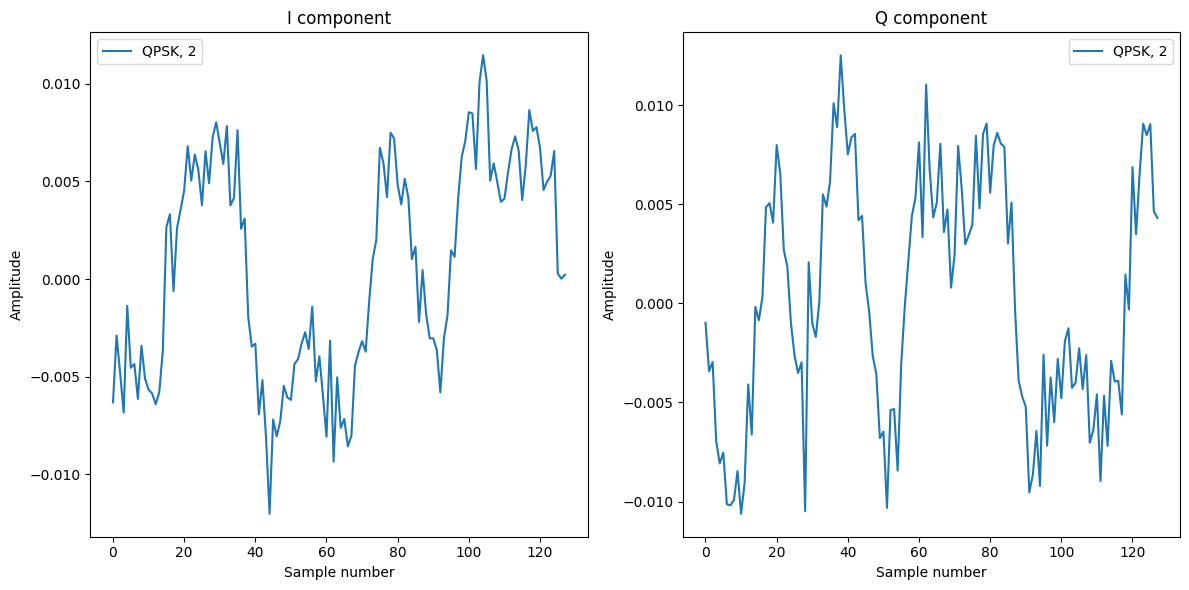

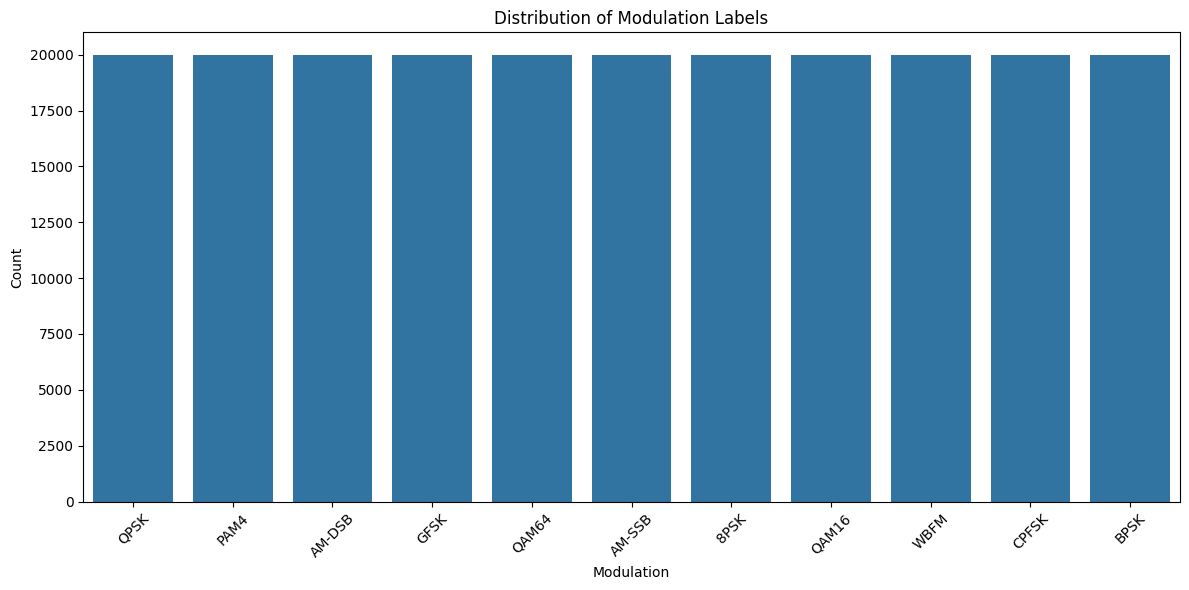

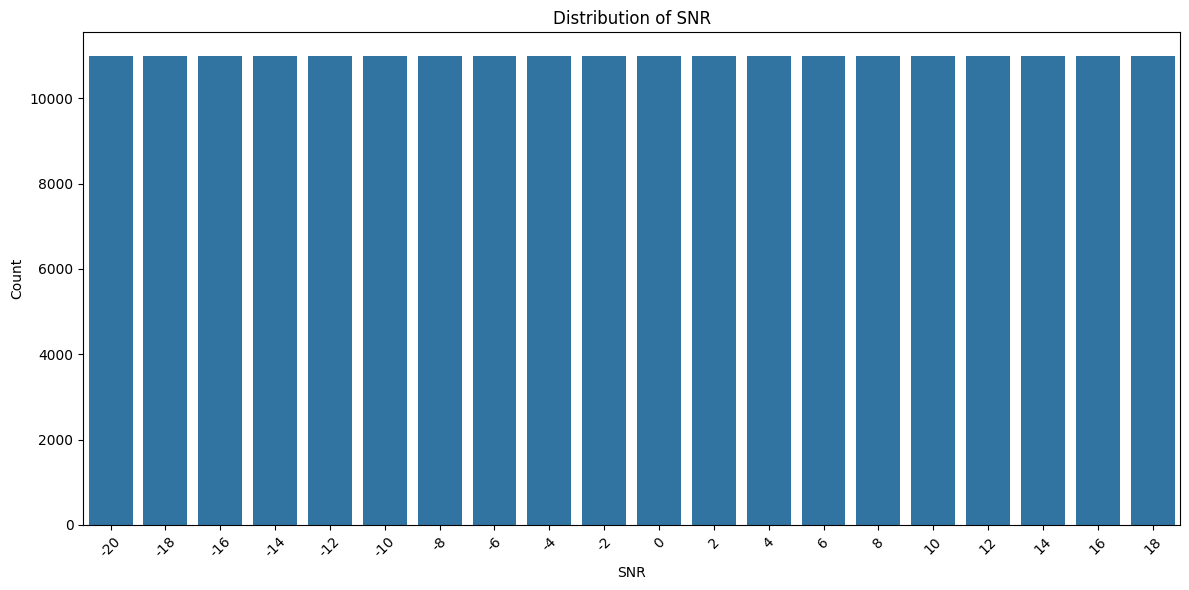

In [3]:
# Prepare data arrays
X = np.vstack([np.transpose(Xd[k], (0, 2, 1)) # Transpose samples to (n_samples, 128, 2)
    for k in Xd.keys()])
modulations = np.array([ # Array of modulation types for each sample
    k[0] for k in Xd.keys() for i in range(Xd[k].shape[0])])
snr_values = np.array([ # Array of SNR levels for each sample
    k[1] for k in Xd.keys() for i in range(Xd[k].shape[0])])

# Visualise a sample's IQ components
view_one = 21 # Index of sample to visualise
view = X[view_one]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(view[:,0],label=f"{modulations[view_one]}, {snr_values[view_one]}")
plt.title("I component")
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(view[:,1],label=f"{modulations[view_one]}, {snr_values[view_one]}")
plt.title("Q component")
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

unique_mods = sorted(list(set(modulations))) # Unique set of modulations
unique_snrs = sorted(list(set(snr_values))) # Unique set of SNRs

# Plot dataset distributions
plt.figure(figsize=(12,6))
sns.countplot(x=modulations)
plt.title("Distribution of Modulation Labels")
plt.xlabel("Modulation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
sns.countplot(x=snr_values)
plt.title("Distribution of SNR")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Data preprocessing

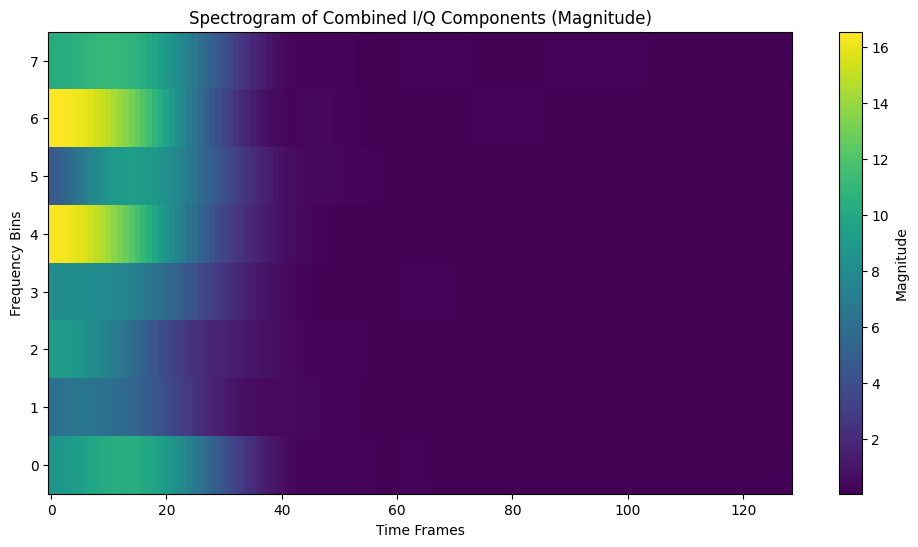

In [4]:
# Convert modulation labels to one-hot encoded vectors
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(modulations)
y = utils.to_categorical(y) # One-hot encoding for multi-class classification

# Split dataset into train/validation/test sets (60/20/20 split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42) # Stratified split preserves class distribution across sets

# Normalise IQ components using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 2)).reshape(X_train.shape) # Reshaped back to original shape
X_val = scaler.transform(X_val.reshape(-1, 2)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

# Signal processing
def stft_transform(x, n_fft=256):
    """Compute combined magnitude spectrogram from IQ components
    Parameters:
        x: Input IQ samples (batch_size, 128, 2)
        n_fft: FFT window size
    Returns:
        Combined magnitude spectrogram (I + Q magnitudes)
    """
    i_stft = tf.signal.stft(
        x[..., 0],  # I component
        frame_length=16,
        frame_step=16, # Window stride
        fft_length=n_fft)
    q_stft = tf.signal.stft(
        x[..., 1],  # Q component
        frame_length=16, # Window size
        frame_step=16,
        fft_length=n_fft)
    stft_output = tf.abs(i_stft) + tf.abs(q_stft) # Combine magnitudes

    return stft_output

# Visualize spectrogram of sample signal
sample_iq = X_train[view_one]
sample_tf = tf.expand_dims(tf.constant(sample_iq, dtype=tf.float32), axis=0)
stft_output = stft_transform(sample_tf)
stft_output_np = stft_output.numpy().squeeze()
plt.figure(figsize=(12,6))
plt.imshow(stft_output_np, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Spectrogram of Combined I/Q Components (Magnitude)")
plt.show()

Multi-View Attention Fusion model architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8, 129)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 129, 1) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 129,    │      1,280 │ reshape[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 129,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 129,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 8)   │      1,024 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 128) │      1,024 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8, 129,    │          0 │ activation[0][0], │
│                     │ 128)              │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 129,    │     73,792 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 129,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8, 129,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 4)   │        256 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 8, 129,    │          0 │ activation_1[0][… │
│ (Multiply)          │ 64)               │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 413,131 (1.58 MB)

 Trainable params: 411,723 (1.57 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 114ms/step - accuracy: 0.4031 - loss: 1.6271 - val_accuracy: 0.5229 - val_loss: 1.2339 - learning_rate: 3.0000e-04
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.5297 - loss: 1.2369 - val_accuracy: 0.5465 - val_loss: 1.1807 - learning_rate: 3.0000e-04
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.5467 - loss: 1.1893 - val_accuracy: 0.5583 - val_loss: 1.1604 - learning_rate: 3.0000e-04
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.5556 - loss: 1.1666 - val_accuracy: 0.5614 - val_loss: 1.1467 - learning_rate: 3.0000e-04
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.5580 - loss: 1.1570 - val_accuracy: 0.5616 - val_loss: 1.1461 - learning_rate: 3.0000e-04
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.5631 - loss: 1.1421 - val_accuracy: 0.5644 - val_loss: 1.1385 - learning_rate: 3.0000e-04
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 

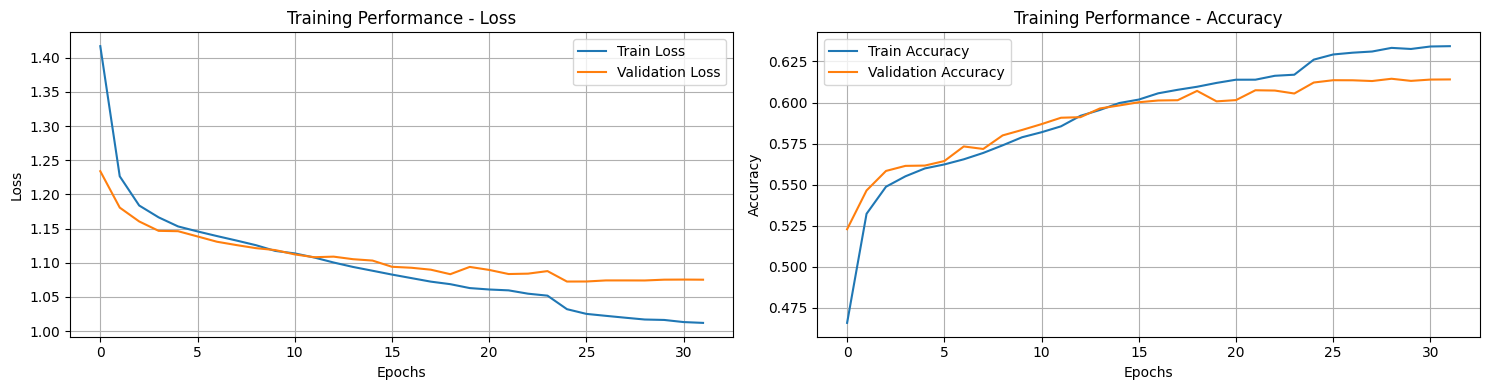

In [5]:
def channel_attention(input_tensor, reduction_ratio=16):
  """
    Squeeze-and-Excitation attention block
    Enhances important frequency channels in spectrogram features
    Args:
        input_tensor: 4D tensor (batch, height, width, channels)
        reduction_ratio: Channel reduction ratio for bottleneck
    Returns:
        Attention-weighted feature tensor
  """
  channel_dim = int(input_tensor.shape[-1])
  x = layers.GlobalAveragePooling2D()(input_tensor) # Global average pooling
  x = layers.Reshape((1, 1, channel_dim))(x)

  # Bottleneck layers
  x = layers.Dense(channel_dim // reduction_ratio, activation='relu', use_bias=False)(x)
  x = layers.Dense(channel_dim, activation='sigmoid', use_bias=False)(x)
  out = layers.Multiply()([input_tensor, x])
  return out

def multi_view_fusion_model(input_shape=(128, 2), num_classes=11):
    """Multi-view attention fusion architecture combining:
    - Temporal features (1D CNN)
    - Spectral features (STFT + 2D CNN)
    - Statistical features (mean + std + range)
    """
    iq_input = layers.Input(shape=input_shape) # Input layer for IQ samples

    # Temporal Branch
    x_time = layers.Conv1D(32, 9, activation='relu', padding='same')(iq_input) # Uses relu activation
    x_time = layers.BatchNormalization()(x_time) # Batch normalisation
    x_time = layers.Conv1D(64, 7, activation='relu', padding='same')(x_time) # Same padding to preserve spatial dimension
    x_time = layers.BatchNormalization()(x_time)
    x_time = layers.Conv1D(128, 5, activation='relu', padding='same')(x_time)
    x_time = layers.BatchNormalization()(x_time)
    x_time = layers.Conv1D(256, 3, activation='relu', padding='same')(x_time)
    x_time = layers.BatchNormalization()(x_time)
    attn = layers.Attention()([x_time, x_time]) # Self-attention for temporal dependencies
    x_time = layers.GlobalAveragePooling1D()(attn)

    # Spectral Branch
    x_frequency = layers.Lambda(stft_transform)(iq_input) # Short-Time Fourier Transform
    x_frequency = layers.Reshape((8, 129, 1))(x_frequency) # (time_frames, freq_bins, channels)
    x_frequency = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x_frequency)
    x_frequency = layers.BatchNormalization()(x_frequency)
    x_frequency = layers.Activation('relu')(x_frequency)
    x_frequency = channel_attention(x_frequency)
    x_frequency = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x_frequency)
    x_frequency = layers.BatchNormalization()(x_frequency)
    x_frequency = layers.Activation('relu')(x_frequency)
    x_frequency = channel_attention(x_frequency)
    x_frequency = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x_frequency)
    x_frequency = layers.Dropout(0.5)(x_frequency)
    x_frequency = layers.BatchNormalization()(x_frequency)
    x_frequency = layers.Activation('relu')(x_frequency)
    x_frequency = channel_attention(x_frequency)
    x_frequency = layers.GlobalAveragePooling2D()(x_frequency)

    # Statistical Branch
    x_stats = layers.Lambda(
        lambda x: tf.concat([
            tf.math.reduce_mean(x, axis=1), # Average signal
            tf.math.reduce_std(x, axis=1), # Signal variability
            tf.math.reduce_max(x, axis=1) - tf.math.reduce_min(x, axis=1) # Dynamic range
        ], axis=-1),
        output_shape=(6,))(iq_input)
    x_stats = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x_stats)
    x_stats = layers.Reshape((1, 64))(x_stats)
    x_stats = layers.GlobalAveragePooling1D()(x_stats)

    # Fusion
    combined = layers.concatenate([x_time, x_frequency, x_stats])
    combined = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(combined) # L2 regularization
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    return Model(iq_input, outputs)

# Model training configuration
model = multi_view_fusion_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

# Training with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5), # Halve learning rate if val_loss stalls for 5 epochs
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)], # Stop training if no improvement for 7 epochs
    verbose=1)

# Training performance visualisation
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Loss plot
ax[0].set_title('Training Performance - Loss')
ax[0].plot(history.epoch, history.history['loss'], label='Train Loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend()

# Accuracy plot
ax[1].set_title('Training Performance - Accuracy')
ax[1].plot(history.epoch, history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()
plt.show()

Multi-View Attention Fusion performance metrics


Final Test Accuracy: 0.6155
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
              precision    recall  f1-score   support

        8PSK       0.81      0.54      0.65      4000
      AM-DSB       0.55      0.71      0.62      4000
      AM-SSB       0.27      0.93      0.42      4000
        BPSK       0.86      0.62      0.72      4000
       CPFSK       0.84      0.63      0.72      4000
        GFSK       0.85      0.65      0.74      4000
        PAM4       0.90      0.71      0.80      4000
       QAM16       0.75      0.53      0.62      4000
       QAM64       0.72      0.63      0.67      4000
        QPSK       0.79      0.57      0.66      4000
        WBFM       0.78      0.24      0.37      4000

    accuracy                           0.62     44000
   macro avg       0.74      0.62      0.64     44000
weighted avg       0.74      0.62      0.64     44000



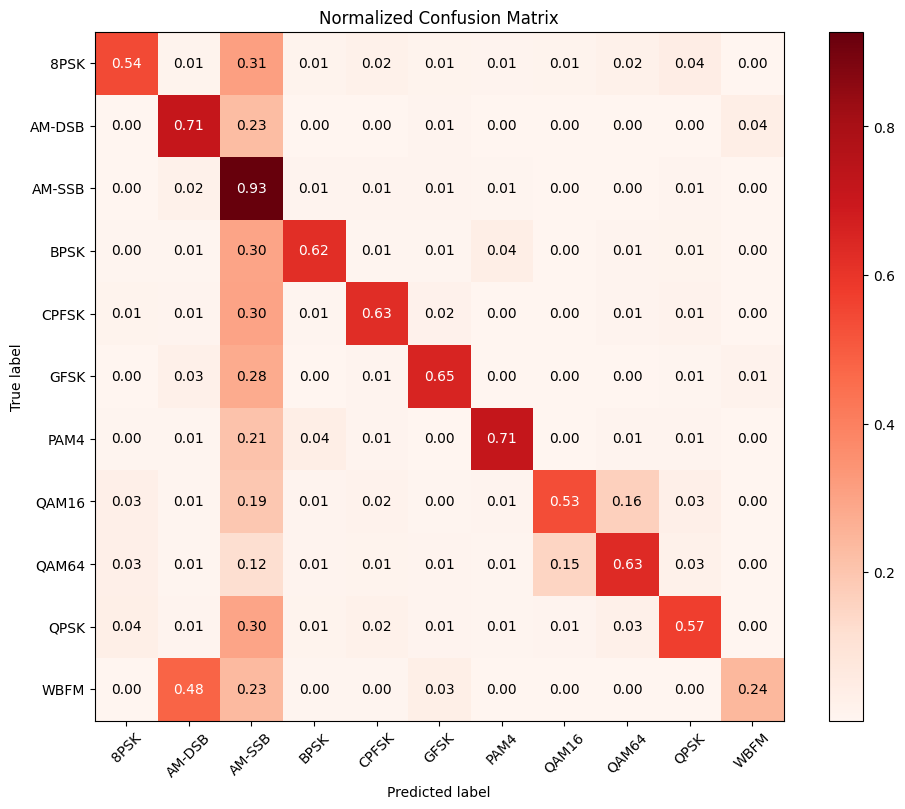

In [6]:
# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}") # Overall test accuracy

# Confusion matrix analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
the_matrix = confusion_matrix(y_true_classes, y_pred_classes)
cm_norm = the_matrix.astype('float') / the_matrix.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(the_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Reds):
  """
  Visualise normalised confusion matrix
  """
  plt.figure(figsize=(10, 8))
  plt.imshow(the_matrix, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if np.max(the_matrix) <= 1.0 else 'd'

  # Add text annotations
  threshold = the_matrix.max() / 2.
  for i in range(the_matrix.shape[0]):
      for j in range(the_matrix.shape[1]):
          plt.text(j, i, format(the_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if the_matrix[i, j] > threshold else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.grid(False)

plot_confusion_matrix(cm_norm, classes=unique_mods, title='Normalized Confusion Matrix', cmap=plt.cm.Reds)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_mods))

Alternative GRU model for comparison

In [7]:
# Alternative model architecture
alt_model = Sequential([
    Bidirectional(GRU(128, return_sequences=True), input_shape=(128,2)),
    Dropout(0.3), # 30% dropout
    GRU(64),
    Dropout(0.3),
    Dense(11, activation='softmax')]) # Final fully connected neural network with Softmax activation

# Alternative model training configuration
alt_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
alt_model.summary()

# Alternative model training history
alt_history = alt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, # Epochs
    batch_size=512, # Batch size
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5),
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1)

# Overall accuracy performance for alternative model
test_loss, test_acc = alt_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       101,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,915 (640.29 KB)

 Trainable params: 163,915 (640.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.1928 - loss: 2.1776 - val_accuracy: 0.3809 - val_loss: 1.5721 - learning_rate: 0.0010
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3967 - loss: 1.5340 - val_accuracy: 0.4489 - val_loss: 1.4186 - learning_rate: 0.0010
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4484 - loss: 1.4168 - val_accuracy: 0.4828 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.4787 - loss: 1.3374 - val_accuracy: 0.5008 - val_loss: 1.2672 - learning_rate: 0.0010
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.4989 - loss: 1.2711 - val_accuracy: 0.5093 - val_loss: 1.2400 - learning_rate: 0.0010
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.5084 - loss: 1.2382 - val_accuracy: 0.5154 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.5

Confusion matrix for alternative model

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


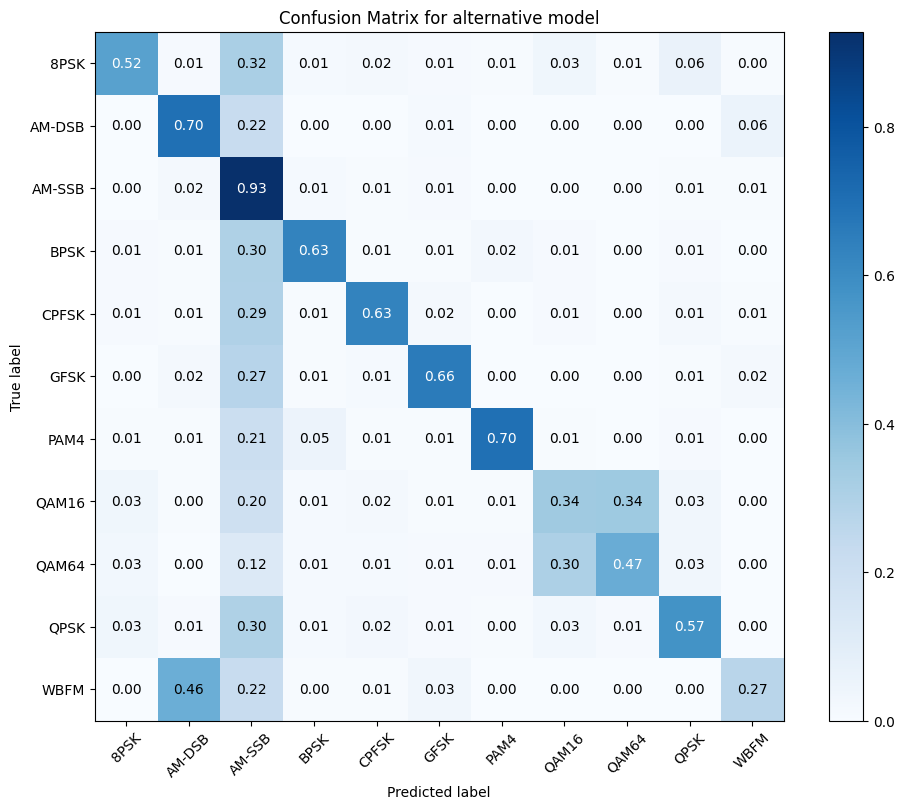

In [8]:
# Confusion matrix analysis for alternative model
y_pred_alt = alt_model.predict(X_test) # Predict classes on test data
y_pred_classes_alt = np.argmax(y_pred_alt, axis=1)
y_true_classes_alt = np.argmax(y_test, axis=1)
the_alt_matrix = confusion_matrix(y_true_classes_alt, y_pred_classes_alt)
cm_norm_alt = the_alt_matrix.astype('float') / the_alt_matrix.sum(axis=1)[:, np.newaxis]

def alt_confusion_matrix(matrix, classes, title='Confusion Matrix for alternative model', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if np.max(matrix) <= 1.0 else 'd'
    threshold = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, format(matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if matrix[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

alt_confusion_matrix(cm_norm_alt, classes=unique_mods, title='Confusion Matrix for alternative model', cmap=plt.cm.Blues)

SNR comparison for main and alternative model

344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
344/344 ━━━━━━━

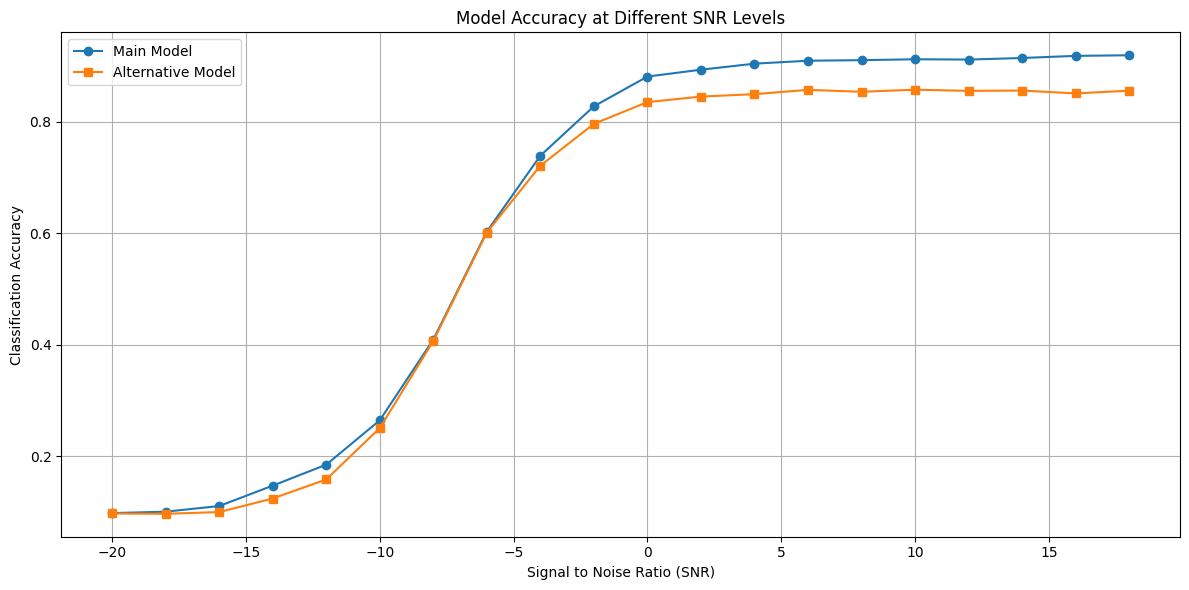

In [9]:
# SNR-accuracy dictionaries
dict_for_plot_main = {} # Multi-View Attention Fusion Model
dict_for_plot_alt = {} # Gated Recurrent Unit

for i in unique_snrs:
    X_snr_values = []
    y_mods = []

    for j in unique_mods:
        key = (j, i)
        if key not in Xd:
            continue
        values = Xd[key]
        for z in values:
            if z.shape == (128, 2):
                X_snr_values.append(z)
            elif z.shape == (2, 128):
                X_snr_values.append(np.transpose(z, (1, 0)))
            y_mods.append(unique_mods.index(j))

    X_snr_values = np.array(X_snr_values)
    y_mods = np.array(y_mods)

    # Normalise test values
    X_snr_scaled = scaler.transform(X_snr_values.reshape(-1, 2)).reshape(X_snr_values.shape)

    y_pred = model.predict(X_snr_scaled) # Main predictions
    y_pred_alt = alt_model.predict(X_snr_scaled) # Alternative predictions

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_classes_alt = np.argmax(y_pred_alt, axis=1)

    accuracy = accuracy_score(y_mods, y_pred_classes)
    alt_accuracy = accuracy_score(y_mods, y_pred_classes_alt)

    # Sort accuracies into dictionaries
    dict_for_plot_main[i] = accuracy
    dict_for_plot_alt[i] = alt_accuracy

# Visualise SNR performance comparison
plt.figure(figsize=(12, 6))
plt.plot(list(dict_for_plot_main.keys()), list(dict_for_plot_main.values()), label="Main Model", marker="o")
plt.plot(list(dict_for_plot_alt.keys()), list(dict_for_plot_alt.values()), label="Alternative Model", marker="s")
plt.xlabel("Signal to Noise Ratio (SNR)")
plt.ylabel("Classification Accuracy")
plt.title("Model Accuracy at Different SNR Levels")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()